# Exercise 4

This week we will practice how to do **data classification and aggregation in Geopandas**. We continue from the last week's exerise with rather similar idea. In this exercise we use data from the [Helsinki Region Travel Time Matrix](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/) as input.


## Problem 1: Join accessibility datasets into a grid and visualize them by using a classifier (10 points)


![P1 example result](img/traveltimes_example.png)

*Desired output from problem 1: Travel times by public transport (PT) and car to Itis and Myyrmanni*

**Data:**

[data/](data/) directory contains all the required input data for this exercise:
 
- Travel time data: `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` (Travel times and distances in the Helsinki Region to different shopping centers  as text files)
- Reference grid: `MetropAccess_YKR_grid_EurefFIN.shp`. 

Column `from_id` in the travel time data sets corresponds to the `YKR_ID` column in the grid shapefile.
     
**Steps:**

In problem 1 we will focus on travel times to **Itis** and **Myyrmanni**. Our goal is to visualize travely times by public transport and car to both shopping centers. Before plotting the maps we need to classify the data. Your task is to **first develop the processing steps using Itis as input**, and then repeat the steps for Myyrmanni.

- Read the Polygon grid `MetropAccess_YKR_grid_EurefFIN.shp` into a GeoDataFrame called `grid` using geopandas:

In [3]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
import geopandas as gpd
import pandas as pd

In [4]:
grid = gpd.read_file('data/MetropAccess_YKR_grid_EurefFIN.shp')

In [5]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nYKR GRID:", len(grid), "rows")


YKR GRID: 13231 rows


- Read the travel time data file for Itis using Pandas into a variable called `data`. Separator is `";"` in the input file.
- Select only following columns from the file:
    
   - `pt_r_t`
   - `car_r_t`
   - `from_id`
   - `to_id`

In [6]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data = pd.read_csv('data/TravelTimes_to_5944003_Itis.txt', sep = ';', usecols=['pt_r_t', 'car_r_t', 'from_id', 'to_id'])

In [7]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nITIS:", len(data), "rows")


ITIS: 13231 rows


- join attributes from `data` to `grid` using the [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function: 
  - **`YKR_ID`** -column in `grid` corresponds to the **`from_id`** column in `data`
  - store the join output into a variable called `data_geo` 

In [8]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data_geo = grid.merge(data, left_on='YKR_ID', right_on='from_id')
data_geo = data_geo[['x', 'y', 'YKR_ID', 'from_id', 'to_id', 'car_r_t', 'pt_r_t', 'geometry']]

In [9]:
# NON-EDITABLE TEST CELL
#Check data type
assert type(data_geo)  == gpd.geodataframe.GeoDataFrame, "output should be a geodataframe"

In [10]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['YKR_ID', 'pt_r_t', 'car_r_t', 'geometry']

assert all(x in data_geo.columns for x in required_columns), "Couldn't find all required columns"

- Remove all rows containing no-data values (-1) from `data_geo`. You can for example [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) the no-data values with numpy's `np.nan`, and then drop rows containing no-data values using the [DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function.

In [11]:
data_geo.replace(to_replace=-1, value=None, inplace=True)

In [12]:
data_geo.dropna(inplace=True)

In [13]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
assert -1 not in data_geo["pt_r_t"], "No data values should be removed from the data!"


- Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
    - Create a `UserDefined` classifier using the [pysal/mapclassify](https://github.com/pysal/mapclassify#userdefined) library using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
    - Apply the classifier to `pt_r_t` and `car_r_t` columns and store the results to `pt_r_t_cl` and `car_r_t_cl` columns, respectively
    - Notice that these 12 class breaks will produce 13 classes (as 1 class break divides the data into two.

In [14]:
import numpy as np
import mapclassify as mc

In [15]:
upper_bounds = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

##### Metodo1: utilizzo di UserDefined classifier per ciscuna colonna separatamente

In [16]:
def get_data_series_classes(data_series, upper_bounds):
    data_series_classes = mc.UserDefined.make(bins = upper_bounds)(data_series)
    return data_series_classes

In [17]:
data_geo['pt_r_t_cl'] = get_data_series_classes(data_geo['pt_r_t'], upper_bounds)
data_geo['car_r_t_cl'] = get_data_series_classes(data_geo['car_r_t'], upper_bounds)

A scopo di documentazione:

In [18]:
ud_classifier = mc.UserDefined(data_geo['pt_r_t'], upper_bounds)

In [19]:
print(ud_classifier)

UserDefined

    Interval       Count
------------------------
[  0.00,   5.00] |     1
(  5.00,  10.00] |    13
( 10.00,  15.00] |    76
( 15.00,  20.00] |   200
( 20.00,  25.00] |   321
( 25.00,  30.00] |   478
( 30.00,  35.00] |   664
( 35.00,  40.00] |   814
( 40.00,  45.00] |   768
( 45.00,  50.00] |   977
( 50.00,  55.00] |  1055
( 55.00,  60.00] |  1010
( 60.00, 202.00] |  6643


In [20]:
data_geo[data_geo['pt_r_t_cl'] == 0]

,x,y,YKR_ID,from_id,to_id,car_r_t,pt_r_t,geometry,pt_r_t_cl,car_r_t_cl
10057,393875.0,6676630.0,5944003,5944003,5944003,0,0,"POLYGON ((394000.000 6676500.000, 393750.000 6...",0,0


##### Metodo 2: Pooled UserDefined classifiers

In [21]:
pooled = mc.Pooled(data_geo[['pt_r_t', 'car_r_t']], classifier = "UserDefined", bins = upper_bounds)

In [22]:
data_geo['pt_r_t_class_pooled'] = pooled.col_classifiers[0].make(bins=upper_bounds)(data_geo['pt_r_t'])
data_geo['car_r_t_class_pooled'] = pooled.col_classifiers[1].make(bins=upper_bounds)(data_geo['car_r_t'])

In [23]:
data_geo

,x,y,YKR_ID,from_id,to_id,car_r_t,pt_r_t,geometry,pt_r_t_cl,car_r_t_cl,pt_r_t_class_pooled,car_r_t_class_pooled
0,381875.0,6697880.0,5785640,5785640,5944003,50,132,"POLYGON ((382000.000 6697750.000, 381750.000 6...",12,9,12,9
1,382125.0,6697880.0,5785641,5785641,5944003,51,135,"POLYGON ((382250.000 6697750.000, 382000.000 6...",12,10,12,10
2,382375.0,6697880.0,5785642,5785642,5944003,58,137,"POLYGON ((382500.000 6697750.000, 382250.000 6...",12,11,12,11
3,382625.0,6697880.0,5785643,5785643,5944003,57,141,"POLYGON ((382750.000 6697750.000, 382500.000 6...",12,11,12,11
4,381125.0,6697630.0,5787544,5787544,5944003,50,125,"POLYGON ((381250.000 6697500.000, 381000.000 6...",12,9,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...
13225,372625.0,6665630.0,6016697,6016697,5944003,59,81,"POLYGON ((372750.000 6665500.000, 372500.000 6...",12,11,12,11
13226,372875.0,6665630.0,6016698,6016698,5944003,60,79,"POLYGON ((373000.000 6665500.000, 372750.000 6...",12,11,12,11
13227,373125.0,6665630.0,6016699,6016699,5944003,62,81,"POLYGON ((373250.000 6665500.000, 373000.000 6...",12,12,12,12
13229,372625.0,6665380.0,6018253,6018253,5944003,61,84,"POLYGON ((372750.000 6665250.000, 372500.000 6...",12,12,12,12


A scopo di documentazione:

In [24]:
pooled.bins

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [25]:
pooled.global_classifier

UserDefined

    Interval       Count
------------------------
[  0.00,   5.00] |     4
(  5.00,  10.00] |   138
( 10.00,  15.00] |   469
( 15.00,  20.00] |  1224
( 20.00,  25.00] |  1925
( 25.00,  30.00] |  2463
( 30.00,  35.00] |  2275
( 35.00,  40.00] |  2394
( 40.00,  45.00] |  2209
( 45.00,  50.00] |  2323
( 50.00,  55.00] |  1951
( 55.00,  60.00] |  1555
( 60.00, 202.00] |  7110

In [26]:
pooled.col_classifiers[0]

Pooled UserDefined

    Interval       Count
------------------------
[  0.00,   5.00] |     1
(  5.00,  10.00] |    13
( 10.00,  15.00] |    76
( 15.00,  20.00] |   200
( 20.00,  25.00] |   321
( 25.00,  30.00] |   478
( 30.00,  35.00] |   664
( 35.00,  40.00] |   814
( 40.00,  45.00] |   768
( 45.00,  50.00] |   977
( 50.00,  55.00] |  1055
( 55.00,  60.00] |  1010
( 60.00, 202.00] |  6643

In [27]:
pooled.col_classifiers[1]

Pooled UserDefined

    Interval       Count
------------------------
[  0.00,   5.00] |     3
(  5.00,  10.00] |   125
( 10.00,  15.00] |   393
( 15.00,  20.00] |  1024
( 20.00,  25.00] |  1604
( 25.00,  30.00] |  1985
( 30.00,  35.00] |  1611
( 35.00,  40.00] |  1580
( 40.00,  45.00] |  1441
( 45.00,  50.00] |  1346
( 50.00,  55.00] |   896
( 55.00,  60.00] |   545
( 60.00, 202.00] |   467

In [28]:
# NON-EDITABLE TEST CELL
#Check the output
print("travel times by public transport:")
print(data_geo[['YKR_ID', 'pt_r_t', 'pt_r_t_cl']].head())

travel times by public transport:
    YKR_ID pt_r_t  pt_r_t_cl
0  5785640    132         12
1  5785641    135         12
2  5785642    137         12
3  5785643    141         12
4  5787544    125         12


In [29]:
# NON-EDITABLE TEST CELL
#Check the output
print("Travel times by car:")
print(data_geo[['YKR_ID','car_r_t', 'car_r_t_cl']].head())

Travel times by car:
    YKR_ID car_r_t  car_r_t_cl
0  5785640      50           9
1  5785641      51          10
2  5785642      58          11
3  5785643      57          11
4  5787544      50           9


**Plot the classified travel times to Itis**:

![itis_example.png](img/itis_example.png)

Create a 1x2 plot where the you plot travel times by public transport and travel times by car to Itis:
- Create subplots using matplotlib having 1 row and 2 columns (use parameters `nrows` & `ncols`), and the figure size should be 10 inches by 5 inches (use parameter `figsize`)
- Add titles for the subplots as seen in the example above
- Remove the empty whitespace around the plots using function `plt.tight_layout()`
- Save the figure into disk with filename `itis_accessibility.png`


In [30]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

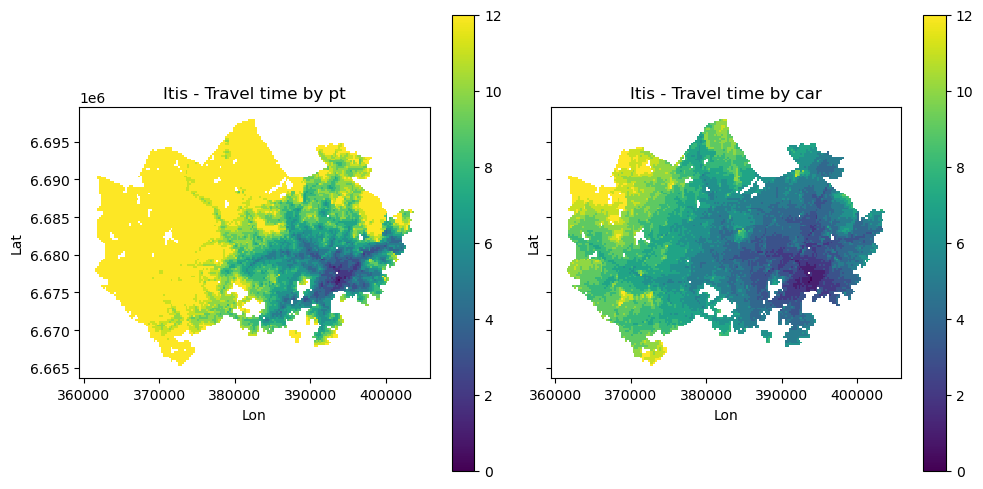

In [58]:
# Define output filename for the figure in here and use it when saving the file:
output_fig1 = "itis_accessibility.png"
nrows, ncols = 1, 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5), sharey=True, label='Class')
data_geo.plot(ax=ax1, column='pt_r_t_cl', legend=True)
data_geo.plot(ax=ax2, column='car_r_t_cl', legend=True)
ax1.set_title("Itis - Travel time by pt")
ax2.set_title("Itis - Travel time by car")
ax1.set_xlabel("Lon")
ax1.set_ylabel("Lat")
ax2.set_xlabel("Lon")
ax2.set_ylabel("Lat")

ax1.set_in_layout(False)
ax2.set_in_layout(False)
plt.tight_layout()
plt.show

In [59]:
plt.savefig(output_fig1)

<Figure size 640x480 with 0 Axes>

In [60]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig1), "figure does not exists!"

**Repeat the steps for Myyrmanni:**

![myyrmanni example figure](img/myyrmanni_example.png)

Next, your task is to repeat all the same steps for **Myyrmanni** (`data/TravelTimes_to_5902043_Myyrmanni.txt`):

    # Read text file using pandas into a variable called data
    # Select columns 'pt_r_t', 'car_r_t', 'from_id', 'to_id'
    # Make table join between grid and travel time data. Store output in a variable called data_geo
    # Remove no data values
    # Classify the values in columns 'pt_r_t', 'car_r_t' into new columns 'pt_r_t_cl', 'car_r_t_cl'
    # Plot travel times by public transport and travel times by car.
    # Save output image to file (myyrmanni_accessibility.png)

*Hint: You can copy paste the code from your earlier solutions in here, just change the input file path.*


In [68]:
data2 = pd.read_csv('data/TravelTimes_to_5902043_Myyrmanni.txt', sep = ';', usecols=['pt_r_t', 'car_r_t', 'from_id', 'to_id'])

In [69]:
data_geo2 = grid.merge(data2, left_on='YKR_ID', right_on='from_id')
data_geo2 = data_geo2[['x', 'y', 'YKR_ID', 'from_id', 'to_id', 'car_r_t', 'pt_r_t', 'geometry']]

In [70]:
data_geo2.replace(to_replace=-1, value=None, inplace=True)

In [71]:
data_geo2.dropna(inplace=True)

In [72]:
data_geo2['pt_r_t_cl'] = get_data_series_classes(data_geo2['pt_r_t'], upper_bounds)
data_geo2['car_r_t_cl'] = get_data_series_classes(data_geo2['car_r_t'], upper_bounds)

<function matplotlib.pyplot.show(close=None, block=None)>

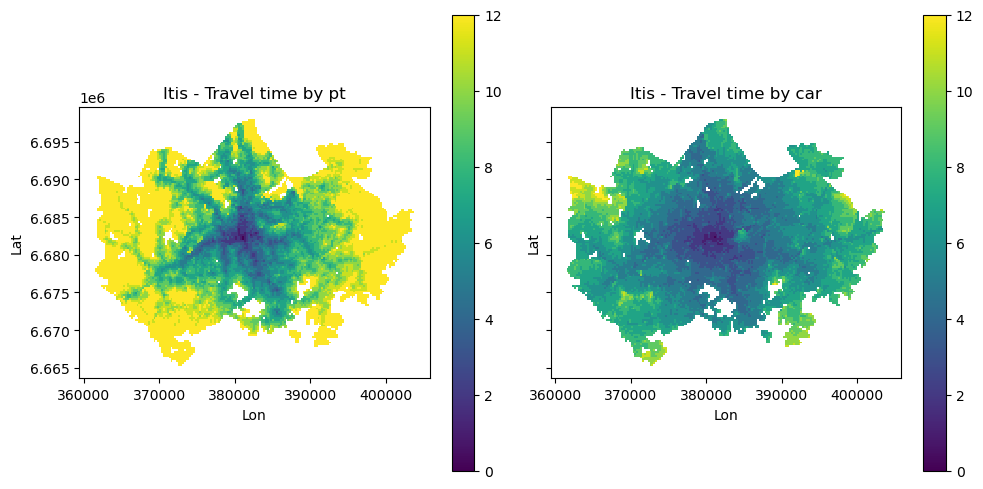

In [75]:
output_fig2 = "myyrmanni_accessibility.png"
nrows, ncols = 1, 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5), sharey=True, label='Class')
data_geo2.plot(ax=ax1, column='pt_r_t_cl', legend=True)
data_geo2.plot(ax=ax2, column='car_r_t_cl', legend=True)
ax1.set_title("Itis - Travel time by pt")
ax2.set_title("Itis - Travel time by car")
ax1.set_xlabel("Lon")
ax1.set_ylabel("Lat")
ax2.set_xlabel("Lon")
ax2.set_ylabel("Lat")

ax1.set_in_layout(False)
ax2.set_in_layout(False)
plt.tight_layout()
plt.show

In [76]:
plt.savefig(output_fig2)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define output filename for the figure in here and use it when saving the file:


In [77]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig2), "figure does not exists!"


**Optional:  4-panel figure** (+2 extra points available if you choose to do this)

As an optional task, plot travel times to Itis and Myyrmanni all in one 4-panel figure (see example at the top of this page)!

Hints:
- create a for-loop where you repeat all the steps for Itis and Myyrmanni (you can iterate over a list of input filepaths)
- Before the for-loop, create a figure with 4 subplots (2 rows and 2 columns) and use figsize=(10,10)
- Inside the for-loop, plot each map into one of the subplots. 
- save the figure as `shopping_center_accessibility.png` 

In [ ]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
raise NotImplementedError()

**Finally**, check that you have provided adequate comments in your code. If you have any thoughts about this exercise, you can write them in here:


YOUR ANSWER HERE

### Done!


**Remember to commit the output figures** to your exercise repository! (One for Itis and one for Myyrmanni, or optionally a combined 4-panel figure for both shopping centers and both travel modes).

That's it, once you have plotted the data and saved the output you are ready to continue with Problem 2.